## Construction of Boolean Network Ensembles

In [1]:
import os
import numpy as np
import pandas as pd
import itertools


In [2]:
filedir = './in_out/'
datadir = filedir + 'z3files/'

In [2]:
rule_info = []
for dfile in [x.split('simbool_')[1] for x in os.listdir(datadir) if 'simbool_' in x]:
    rules = pd.read_table(datadir + dfile, header=None)
    unique_ = []
    for i in range(rules.shape[0]-2):
        try:
            unique_.append(eval(rules.iloc[i+2,0])[-1])
        except SyntaxError:
            continue
    unique_values = [float(x.split('score ')[1]) for x in unique_]
    max_score = np.max(unique_values) 
    max_idx = np.where(unique_values == max_score)[0]
    
    rule_info.append([dfile, rules.iloc[0,0], set(unique_), len(unique_), max_score, max_idx, len(max_idx)])
    
rule_infos = pd.DataFrame(rule_info, columns = ['node','level','score_dict','num','max','maxi_idx','max_num'])
rule_infos = rule_infos.astype({'max': 'float64'})
# rule_infos.sort_values(by='max')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 [Text(0, 0, 'Elf2.txt'),
  Text(1, 0, 'Ppargc1a.txt'),
  Text(2, 0, 'Hdac2.txt'),
  Text(3, 0, 'Klf4.txt'),
  Text(4, 0, 'Acaa1b.txt'),
  Text(5, 0, 'Bmyc.txt'),
  Text(6, 0, 'Bhlhe40.txt'),
  Text(7, 0, 'Kdm7a.txt'),
  Text(8, 0, 'Aco1.txt'),
  Text(9, 0, 'Gmeb1.txt'),
  Text(10, 0, 'Tfdp2.txt'),
  Text(11, 0, 'Zmiz1.txt'),
  Text(12, 0, 'Tbx3.txt'),
  Text(13, 0, 'Esrra.txt'),
  Text(14, 0, 'Myc.txt'),
  Text(15, 0, 'Ezh2.txt'),
  Text(16, 0, 'Zfp704.txt'),
  Text(17, 0, 'Smc3.txt'),
  Text(18, 0, 'Pole3.txt'),
  Text(19, 0, 'Hif1a.txt'),
  Text(20, 0, 'Pole4.txt'),
  Text(21, 0, 'Mafb.txt'),
  Text(22, 0, 'Maf.txt'),
  Text(23, 0, 'Mxi1.txt'),
  Text(24, 0, 'Creb3l2.txt'),
  Text(25, 0, 'Hes6.txt'),
  Text(26, 0, 'Hes1.txt'),
  Text(27, 0, 'Sox9.txt'),
  Text(28, 0, 'Nelfe.txt'),
  Text(29, 0, 'Rara.txt'),
  Te

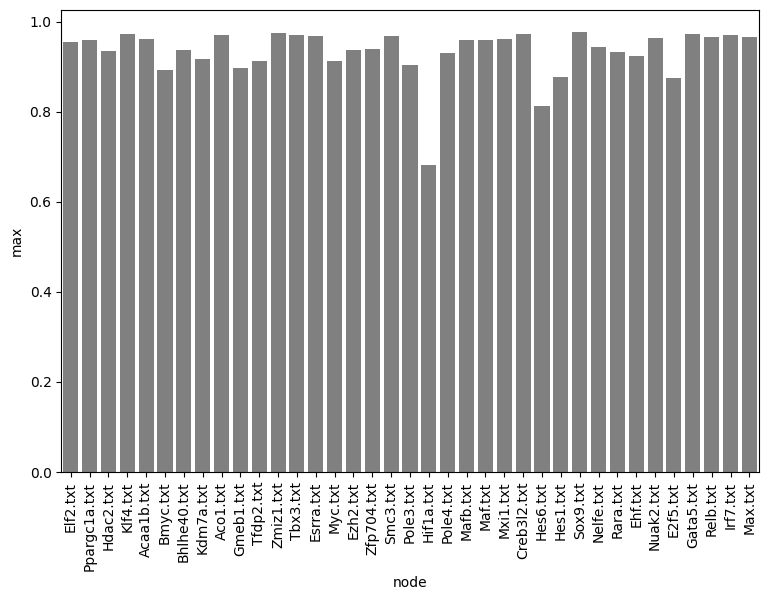

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
fig = plt.figure(figsize=(9, 6))
ax = sns.barplot(data = rule_infos, x='node',y='max',color='grey')
plt.xticks(rotation=90)

In [7]:
# (1) re-write simbool_text having max z-score

for idx in range(rule_infos.shape[0]):
    tmp = rule_infos.iloc[idx,:]
    gene = tmp[0].split('.txt')[0]
    array_idx = tmp[5]
    
    lines = []
    read_idx = 0
    with open(datadir + 'simbool_' + gene + '.txt', 'r') as f:
        while 1:
            line = f.readline()
            if line == '': break
            if read_idx in array_idx: lines.append(line)
            read_idx += 1
            
    with open(datadir + 'simbool2_' + gene + '.txt', 'w') as f:
        f.write(''.join(lines))


In [8]:
# (2) filter interaction? (not mandatory)

interaction_add='./in_out/'+'4_gene_interactions.txt'
interactions = pd.read_table(interaction_add)
# print(interactions.shape)
# interactions_filtered = interactions.loc[interactions.DREMI>=0.23,:] # cancer

interactions_filtered = interactions
print(interactions_filtered.shape)

# interactions_filtered
inf_group1 = interactions_filtered.iloc[:,[0,1,6]].groupby('gene2').aggregate(list)
inf_group2 = interactions_filtered.iloc[:,[0,1,2]].groupby('gene2').aggregate(list)

def select_MI(x,y_list):
    mi_ = []
    pr_ = []

    for y in y_list:
        mi_.append(inf_group1.loc[x]['DREMI'][np.where([y == p for p in inf_group1.loc[x]['gene1']])[0][0]])
        pr_.append(inf_group2.loc[x]['pearson'][np.where([y == p for p in inf_group2.loc[x]['gene1']])[0][0]])
    pr_ = [abs(x) for x in pr_]
    return mi_, pr_
    

(1369, 7)


In [9]:
from BF_codes.BF_checkers import *
import copy
import numpy as np
from pyboolnet.file_exchange import bnet2primes, primes2bnet
from pyboolnet.state_transition_graphs import primes2stg, successor_synchronous
from pyboolnet.interaction_graphs import primes2igraph  

def strip_(str_):
    while 1:
        if '(' in str_: str_ = str_[1:]
        if ')' in str_: str_ = str_[:-1]
        if ('(' not in str_) & (')' not in str_): break
    return str_
    
def make_boolstring(k, logic):
    num = 2**k
    prime = bnet2primes(logic)
    binary_vector = []
    for n in range(num):
        bin_ = bin(n).split('b')[1]
        state = ''.join(['0' for _ in range(k-len(bin_))])+bin_
        
        gene = logic.split(',')[0]
        gene_idx = np.where([x == gene for x in  list(prime.keys())])[0][0]
        if k != len(prime.keys()):
            state_ = state[:gene_idx] + '0' + state[gene_idx:]
        else:
            state_ = state
        successor_synchronous(prime, state_)
        bool_str = successor_synchronous(prime, state_)[gene]
        binary_vector.append(str(bool_str))
        #print(state, bool_str)
    binary_vector = ''.join(binary_vector)
    return binary_vector

def returnNCF_sen(simbool):
    allbools = list(([simbool.iloc[x,0].replace('*=',', ') for x in range(len(simbool))]))
    allbool = list(([simbool.iloc[x,0].split('*=')[1] for x in range(len(simbool))]))      
    num_k = [len([strip_(x) for x in y.split(' ') if ('and' not in x.strip()) & ('not' not in x.strip()) & ('or' not in x.strip())]) for y in allbool]

    is_NCFs = []
    avg_sens = []
    for k, logic in zip(num_k, allbools):
        logic = logic.replace(' or ', ' | ')
        logic = logic.replace(' and ', ' & ')
        logic = logic.replace('not ', '!')
        binary_vector = make_boolstring(k, logic)

        is_NCFs.append((check_if(k,binary_vector).is_any_types())['NCF'])
        avg_sens.append(bf(k, binary_vector).avg_sensitivity())  # returns the average sensitivity of the BF (between 1 and k)

    return is_NCFs, avg_sens

def returnScore(simbools, gene):
    simbool = copy.deepcopy(simbools)
    simbool.index = list(range(simbool.shape[0]))
    allbool = list(([simbool.iloc[x,0].split('*=')[1] for x in range(len(simbool))])) 
    ch_ = [([strip_(x) for x in y.split(' ') if ('and' not in x.strip()) & ('not' not in x.strip()) & ('or' not in x.strip())]) for y in allbool]

    # is_MI
    is_MIs = [set(ch)-set(inf_group1.loc[gene]['gene1'])==set() for ch in ch_]
    is_NCFs, avg_sens = returnNCF_sen(simbool)
    filtered = [np.all([x,y]) for x,y in zip(is_MIs,is_NCFs)]

    score1 = []
    score2 = []
    for ch, ft in zip(ch_,filtered):
        if ft == True:
            mi_s, pr_s = select_MI(gene,ch)
            score1.append(np.mean(mi_s))
            score2.append(np.mean(pr_s))
        else:
            score1.append(0)
            score2.append(0)
    
    if np.max(score1) > 0 :
        max_bool1 = allbool[np.argmax(score1)]
        max_bool2 = allbool[np.argmax(score2)]
        df_logic = pd.concat([simbool,pd.DataFrame([[gene for _ in range(len(score1))], score1, score2, avg_sens, filtered]).T],axis=1)
        df_logic.columns = ['simbool','gene','meanMI','meanPr','avgSen','filtered']
    else: #filtered = None
        max_bool1 = gene; max_bool2 = gene;
        df_logic = pd.DataFrame([gene+'*='+gene, gene, 100, 100, 100, True]).T
        df_logic.columns = ['simbool','gene','meanMI','meanPr','avgSen','filtered']

    
    df_logic = df_logic.loc[[x ==True for x in df_logic.loc[:,'filtered']],:]
    df_logic = df_logic.sort_values(by='meanMI',ascending=False)[:3]
    print(df_logic.shape)
    return df_logic, max_bool1, max_bool2


def check_ensemble(ensemble_dir, ensemble_results):
    for networkN in sorted(set(os.listdir(ensemble_dir)) - set([x[0] for x in ensemble_results])):
        print(networkN)
        with open(ensemble_dir + networkN, 'r') as f:
            allbools = f.read().splitlines()
        allbools = [x for x in allbools if x != '']
        allbool = list(([allbools[x].split(', ')[1].strip() for x in range(len(allbools))]))    
        num_k = [len(set([strip_(x) for x in y.split(' ') if ('&' not in x.strip())  & ('|' not in x.strip())])) for y in allbool]

        is_NCFs = []
        avg_sens = []
        for k, logic in zip(num_k, allbools):
            logic = logic.replace(' or ', ' | ')
            logic = logic.replace(' and ', ' & ')
            logic = logic.replace('not ', '!')
            binary_vector = make_boolstring(k, logic)

            is_NCFs.append((check_if(k,binary_vector).is_any_types())['NCF'])
            avg_sens.append(bf(k, binary_vector).avg_sensitivity())  # returns the average sensitivity of the BF (between 1 and k)
        ensemble_results.append([networkN, np.all(is_NCFs), np.mean(avg_sens),np.std(avg_sens)])
    return ensemble_results

In [3]:
# (3) Select Top3 logic based on meanMI value

import networkx as nx
all_logics = []
all_primes = []
checked = []

filedir = './in_out/'

datadir = filedir + 'z3files/'

all_logics_info = pd.DataFrame([])
for dfile in  [x for x in os.listdir(datadir) if 'simbool2_' in x]:
    simbool = pd.read_table(datadir + dfile, header=None).drop_duplicates()
    allbool = list(([simbool.iloc[x,0].split('*=')[1] for x in range(len(simbool))]))
    print(dfile, len(allbool))
    gene = simbool.iloc[0,0].split('*=')[0]
    df_logic, max_bool1, _ = returnScore(simbool, gene) # max_bool1 = meanMI # top3
    all_logics_info = pd.concat([all_logics_info, df_logic])
    all_logics.append(gene + ', ' + max_bool1)

    
logic = '\n'.join(all_logics)
logic = logic.replace(' or ', ' | ')
logic = logic.replace(' and ', ' & ')
logic = logic.replace('not ', '!')
print(logic,'\n')
primes = bnet2primes(logic)

graph = primes2igraph(primes)
G = nx.DiGraph()
G.add_edges_from([(x[0],x[1],{'sign':float(list(x[2]['sign'])[0])}) for x in graph.edges(data=True)])
print('cycle',list(nx.simple_cycles(G)))

bnets1 = primes2bnet(primes, filedir+"GRNs_MI.bnet")
all_logics_info.index = range(all_logics_info.shape[0])
all_logics_info.to_csv(filedir+"all_logics_info.csv")

In [14]:
all_logics_info

,simbool,gene,meanMI,meanPr,avgSen,filtered
0,Smc3*=((Smc3 and Ezh2) and Pole4) and not Bhlhe40,Smc3,1.981192,0.912828,0.5,True
1,Smc3*=(Smc3 and Ezh2) and not Bhlhe40,Smc3,1.969674,0.893721,0.75,True
2,Smc3*=((Smc3 and Ezh2) and Hdac2) and not Bhlhe40,Smc3,1.902713,0.909213,0.5,True
3,Nuak2*=(Ppargc1a and Maf) and not (Zfp704 and ...,Nuak2,1.056993,0.811838,1.0,True
4,Nuak2*=((Kdm7a and Maf) and Ppargc1a) and not ...,Nuak2,1.014307,0.802105,0.6875,True
...,...,...,...,...,...,...
100,Hes1*=Ehf and not (Esrra or Maf),Hes1,1.35291,0.89732,0.75,True
101,Hes1*=Ehf and not (Aco1 or Maf),Hes1,1.349221,0.898432,0.75,True
102,Ehf*=Hdac2 and not (Irf7 and Maf),Ehf,1.207737,0.891025,1.25,True
103,Ehf*=Hdac2 and not Irf7,Ehf,1.145904,0.864559,1.0,True


In [4]:
# (4) Generate all possible combination networks

import itertools
import shutil
from pyboolnet.interaction_graphs import primes2igraph

model_num = 1000
tmp = all_logics_info.loc[all_logics_info.meanMI != 0,:]
tmp = tmp.dropna()
tmp = tmp.sort_values(by='avgSen',ascending=False) # sorted logic table

nodes = list(set(tmp.gene))
node_logics = tmp.loc[:,['gene','simbool']].groupby('gene').aggregate(list).to_dict()['simbool']

# Generate all possible combinations of Boolean logics for the nodes
all_logics = []
for node in nodes:
    all_logics.append(node_logics[node])
    
try: shutil.rmtree(filedir+"ensemble_filtered/"); os.mkdir(filedir+"ensemble_filtered/");
except FileNotFoundError: os.mkdir(filedir+"ensemble_filtered/")

for i_x, model_x in enumerate(itertools.product(*all_logics)):
    if i_x == model_num: break

    logic = '\n'.join(model_x)
    logic = logic.replace('*=', ', ')
    logic = logic.replace(' or ', ' | ')
    logic = logic.replace(' and ', ' & ')
    logic = logic.replace('not ', '!')
    
    primes = bnet2primes(logic)
    graph = primes2igraph(primes)
    
    connected_node = max(nx.connected_components(graph.to_undirected()), key=len)
    primes_new = {x:y for x,y in primes.items() if x in connected_node}
    print(len(primes.keys()), len(primes_new.keys()))
    bnets = primes2bnet(primes_new, filedir+"ensemble_filtered/"+str(i_x)+"_GRN.bnet")


In [7]:
ensemble_dir = filedir+"ensemble_filtered/"
ensemble_results = []
ensemble_results = check_ensemble(ensemble_dir,ensemble_results)

In [8]:
pd_ensemble_results = pd.DataFrame(ensemble_results)
pd_ensemble_results.columns = ['network','np.all(is_NCFs)', 'np.mean(avg_sens)','np.std(avg_sens)']
pd_ensemble_results = pd_ensemble_results.sort_values(by='np.mean(avg_sens)',ascending=False)
pd_ensemble_results.to_csv(filedir+'ensemble_result.csv')
max_net = pd_ensemble_results.loc[pd_ensemble_results.iloc[:,2] == np.max(pd_ensemble_results.iloc[:,2]),:]
max_net

In [9]:
# Network Ensemble

cancer_marker = [...]
normal_marker = [...]

print(cancer_marker)
print(normal_marker)

In [10]:
try: shutil.rmtree(filedir+"ensemble_filteredt/"); os.mkdir(filedir+"ensemble_filteredt/");
except FileNotFoundError: os.mkdir(filedir+"ensemble_filteredt/")

for networkN in list(max_net.network):
    model_file = filedir+"ensemble_filtered/" + networkN
    primes = bnet2primes(model_file)
    print(model_file)

    graph = primes2igraph(primes)
    G = nx.DiGraph()
    G.add_edges_from([(x[0],x[1],{'sign':float(list(x[2]['sign'])[0])}) for x in graph.edges(data=True)])

    #print('cycle',list(nx.simple_cycles(G)))
    removed = set([x for x,y in dict(G.out_degree()).items() if y == 0]) - set(cancer_marker | normal_marker)
    
    
    primes_new = {x:y for x,y in primes.items() if x not in removed}
    print(len(primes.keys()), len(primes_new.keys()))
    bnets = primes2bnet(primes_new, filedir+"ensemble_filteredt/Trimmed_"+networkN)


In [28]:
from collections import defaultdict
prime_set = defaultdict(dict)

for networkN in os.listdir(filedir+"ensemble_filteredt/"): 
    model_file = filedir+"ensemble_filteredt/" + networkN
    primes = bnet2primes(model_file)
    prime_set[model_file] = primes

In [11]:
merged = []
unique = []
for i,x in enumerate(prime_set.values()):
    for j,y in enumerate(prime_set.values()):
        if (i not in merged) & (i!=j):
            if x == y:
                merged.append(j)
    if i not in merged:
        unique.append(i)
                
# print(unique)